# Recommender Systems 2020/21

### Practice - Collaborative Boosted FW


### Underlying idea... the way to capture the feature importance from the user point of view, is to... use their point of view (e.g., ratings, collaborative similarity)

## A few info about feature weightign techniques

* Information retrieval methods (TF-IDF, BM25..) do not optimize a predictive model
* Embedding methods (FISM, UFSM, Factorization Machines) optimize everything at the same time, model and weights, but are difficult to train and sensitive to noise
* Wrapper methods (LFW, CFW) apply a two step approach approximating an already built collaborative model, more robust and easier to tune


In [1]:
import numpy as np
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Data_manager.Movielens.Movielens10MReader import Movielens10MReader

data_reader = Movielens10MReader()
data_loaded = data_reader.load_data()

URM_all = data_loaded.get_URM_all()
ICM_tags = data_loaded.get_ICM_from_name("ICM_tags")
ICM_genres = data_loaded.get_ICM_from_name("ICM_genres")

Movielens10M: Verifying data consistency...
Movielens10M: Verifying data consistency... Passed!
DataReader: current dataset is: <class 'Data_manager.Dataset.Dataset'>
	Number of items: 10681
	Number of users: 69878
	Number of interactions in URM_all: 10000054
	Value range in URM_all: 0.50-5.00
	Interaction density: 1.34E-02
	Interactions per user:
		 Min: 2.00E+01
		 Avg: 1.43E+02
		 Max: 7.36E+03
	Interactions per item:
		 Min: 0.00E+00
		 Avg: 9.36E+02
		 Max: 3.49E+04
	Gini Index: 0.57

	ICM name: ICM_genres, Value range: 1.00 / 1.00, Num features: 20, feature occurrences: 21564, density 1.01E-01
	ICM name: ICM_tags, Value range: 1.00 / 69.00, Num features: 10217, feature occurrences: 108563, density 9.95E-04
	ICM name: ICM_all, Value range: 1.00 / 69.00, Num features: 10237, feature occurrences: 130127, density 1.19E-03




In [2]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.9)

### To shorten the notebook let's use the parameters we computed the previous time (Warning: not very clean, the data split may be different, also, running BayesianSearch multiple times may result in a different solution)

In [3]:
best_params_ItemKNNCF = {'topK': 700, 'shrink': 200, 'similarity': 'cosine', 'normalize': True}
best_params_ItemKNNCBF = {'topK': 500, 'shrink': 1000, 'similarity': 'cosine', 'normalize': True}

### Step 1: Create the two models, collaborative and content based

In [4]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender


itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit(**best_params_ItemKNNCF)

itemKNNCBF = ItemKNNCBFRecommender(URM_train, ICM_tags)
itemKNNCBF.fit(**best_params_ItemKNNCBF)

ItemKNNCFRecommender: URM Detected 49 (0.46 %) cold items.
Similarity column 10681 ( 100 % ), 899.83 column/sec, elapsed time 0.20 min
ItemKNNCBFRecommender: URM Detected 49 (0.46 %) cold items.
Similarity column 10681 ( 100 % ), 9965.86 column/sec, elapsed time 0.02 min


### Question, how the two similarities differ?

In [5]:
W_sparse_CF = itemKNNCF.W_sparse
W_sparse_CBF = itemKNNCBF.W_sparse

## Let's plt the global similarity distribution 

In [6]:
W_sparse_CF_sorted = np.sort(W_sparse_CF.data.copy())
W_sparse_CBF_sorted = np.sort(W_sparse_CBF.data.copy())

In [7]:
W_sparse_CF_sorted

array([7.9525911e-05, 8.0648650e-05, 8.8569628e-05, ..., 5.9590876e-01,
       6.0201591e-01, 6.0201591e-01], dtype=float32)

In [8]:
W_sparse_CBF_sorted

array([5.2332488e-04, 5.8817206e-04, 5.9291383e-04, ..., 6.8691748e-01,
       6.9236338e-01, 6.9236338e-01], dtype=float32)

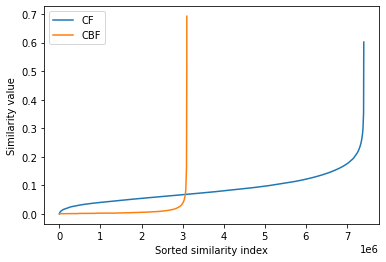

In [9]:
import numpy as np
import matplotlib.pyplot as pyplot


pyplot.plot(W_sparse_CF_sorted, label = 'CF')
pyplot.plot(W_sparse_CBF_sorted, label = 'CBF')
pyplot.ylabel('Similarity value')
pyplot.xlabel('Sorted similarity index')
pyplot.legend()
pyplot.show()

## Let's now plot the delta for the common values

In [10]:
# Get common structure
W_sparse_CF_structure = W_sparse_CF.copy()
W_sparse_CF_structure.data = np.ones_like(W_sparse_CF_structure.data)

W_sparse_CBF_structure = W_sparse_CBF.copy()
W_sparse_CBF_structure.data = np.ones_like(W_sparse_CBF_structure.data)

W_sparse_common = W_sparse_CF_structure.multiply(W_sparse_CBF_structure)

# Get values of both in common structure of CF
W_sparse_delta = W_sparse_CBF.copy().multiply(W_sparse_common)
W_sparse_delta -= W_sparse_CF.copy().multiply(W_sparse_common)

In [11]:
W_sparse_delta_sorted = np.sort(W_sparse_delta.data.copy())

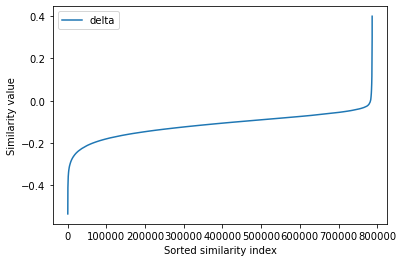

In [12]:
pyplot.plot(W_sparse_delta_sorted, label = 'delta')
pyplot.ylabel('Similarity value')
pyplot.xlabel('Sorted similarity index')
pyplot.legend()
pyplot.show()

In [13]:
# How many values we have in common?

print("W_sparse_CF has {:.2E} values and {:.2f} % in common with CBF".format(W_sparse_CF.nnz, W_sparse_common.nnz/W_sparse_CF.nnz*100))
print("W_sparse_CBF has {:.2E} values and {:.2f} % in common with CF".format(W_sparse_CBF.nnz, W_sparse_common.nnz/W_sparse_CBF.nnz*100))

print("W_sparse_delta has {:.2E} values".format(W_sparse_delta.nnz))


W_sparse_CF has 7.41E+06 values and 10.62 % in common with CBF
W_sparse_CBF has 3.10E+06 values and 25.38 % in common with CF
W_sparse_delta has 7.87E+05 values


## What do we see?
## The great majority of similarities are not common... the models are modeling two very different phenomena

# Idea: 

## what if we were to weight features in such a way to approximate as well as possible the collaborative similarity?

### Basic model:  $S_{CBF} = ICM \cdot diag(feature\_weights) \cdot ICM^{T}$ 


### We want  $S_{CBF} = S_{CF}$

### Hence we wish to find the weights such that  $S_{CF} = ICM \cdot diag(feature\_weights) \cdot ICM^{T}$ 

### Now, we can rearrange the equations considering that we need only weights for features the two items have in common... this becomes a regression problem in form Ax = b. In our case A are the common features, x the weights and b the collaborative similarity


### Since it is a regression problem, we can use an already available solver like linalg in scipy.sparse

### It takes as imput two data structures, one is sparse and the other is the target value

In [14]:
W_sparse_delta = W_sparse_delta.tocoo()


item_index_1 = W_sparse_delta.row[666]
item_index_2 = W_sparse_delta.col[666]

In [15]:
print("Item indices are {} and {}".format(item_index_1, item_index_2))

Item indices are 7 and 14


In [16]:
print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))

Collaborative similarity value is 0.5295509099960327
Content-based similarity value is 0.24285197257995605


### Compute the common features

In [17]:
common_features = ICM_tags[item_index_1,:].multiply(ICM_tags[item_index_2,:])
common_features

<1x10217 sparse matrix of type '<class 'numpy.float64'>'
	with 25 stored elements in Compressed Sparse Row format>

In [18]:
common_features.indices

array([  72,   73,  123,  138,  145,  146,  150,  246,  313,  511,  516,
        561,  605,  714,  888,  918, 1155, 1514, 2091, 2357, 2462, 2463,
       2579, 4573, 8075], dtype=int32)

## These items have just a common feature, that is a common scenario

### Let's look for items having  a few features in common, say 5

In [19]:
min_common_features = 5

for inner_index in range(len(W_sparse_delta.row)):

    item_index_1 = W_sparse_delta.row[inner_index]
    item_index_2 = W_sparse_delta.col[inner_index]

    common_features = ICM_tags[item_index_1,:].multiply(ICM_tags[item_index_2,:])
    
    if common_features.nnz >= min_common_features:
        
        # Bad programming, don't do this at home
        break
        
        

print("Item indices are {} and {}".format(item_index_1, item_index_2))

print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))
    
common_features.indices

Item indices are 1 and 11
Collaborative similarity value is 0.3872489929199219
Content-based similarity value is 0.10348083078861237


array([   8,  494,  678,  679, 2634], dtype=int32)

In [20]:
from scipy.sparse import linalg

loss_tolerance = 1e-6
iteration_limit = 50000
damp_coeff=0.0

W_sparse_CF_value = W_sparse_CF[item_index_1, item_index_2]

In [21]:
linalg_result = linalg.lsqr(common_features, W_sparse_CF_value, show = False,
                            atol=loss_tolerance, btol=loss_tolerance,
                            iter_lim = iteration_limit, damp=damp_coeff)

In [22]:
feature_weights = linalg_result[0].copy()
feature_weights

array([0., 0., 0., ..., 0., 0., 0.])

In [23]:
feature_weights[common_features.indices]

array([3.38969983e-04, 4.84242832e-05, 3.05072984e-03, 3.05072984e-03,
       1.45272850e-04])

### Note that all weights will be zeros except for the features those items have in common, nothing can be learned if a feature is not common

### If a dataset has a very sparse ICM, this FW method will struggle

In [24]:
new_CBF_value = common_features.dot(feature_weights)
new_CBF_value

array([0.38724899])

In [25]:
print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))

print("Weighted Content-based similarity value is {}".format(new_CBF_value[0]))

Collaborative similarity value is 0.3872489929199219
Content-based similarity value is 0.10348083078861237
Weighted Content-based similarity value is 0.38724899291992176


### Note that we learned the CF similarity amost exactly...

### Warning: 5 common features and 1 similarity value, more parameters than data points, overfitting!

### if we want to apply this method to the whole dataset we have to compute the common features of all items having a common similarity value. Whe already know who they are, thanks to W_sparse_delta

In [26]:
from FeatureWeighting.CFW_D_Similarity_Linalg import CFW_D_Similarity_Linalg

In [27]:
CFW_weithing = CFW_D_Similarity_Linalg(URM_train, ICM_tags, W_sparse_CF)
CFW_weithing.fit()

CFW_D_Similarity_Linalg: URM Detected 49 (0.46 %) cold items.
CFW_D_Similarity_Linalg: Generating train data
Similarity column 10681 ( 100 % ), 14888.50 column/sec, elapsed time 0.01 min
CFW_D_Similarity_Linalg: Collaborative S density: 6.49E-02, nonzero cells 7408876
CFW_D_Similarity_Linalg: Content S density: 1.73E-02, nonzero cells 1976311
CFW_D_Similarity_Linalg: Content S structure has 566789 out of 1976311 ( 28.68%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 7.51E+04, average is: 1.32E-01, average over all collaborative data is 8.65E-02
Similarity column 10681 ( 100 % ), 16694.89 column/sec, elapsed time 0.01 min


In [28]:
from Base.Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[5])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[5])


In [29]:
results_dict, _ = evaluator_test.evaluateRecommender(itemKNNCF)
results_dict

EvaluatorHoldout: Processed 34000 ( 48.71% ) in 30.23 sec. Users per second: 1125
EvaluatorHoldout: Processed 68000 ( 97.42% ) in 1.01 min. Users per second: 1122
EvaluatorHoldout: Processed 69804 ( 100.00% ) in 1.04 min. Users per second: 1120


{5: {'ROC_AUC': 0.43311749087922413,
  'PRECISION': 0.3117099306630827,
  'PRECISION_RECALL_MIN_DEN': 0.31834851870960196,
  'RECALL': 0.10381715744556805,
  'MAP': 0.2338118477769968,
  'MRR': 0.5153410501785864,
  'NDCG': 0.15113096399648668,
  'F1': 0.15575802336397737,
  'HIT_RATE': 1.5585496533149963,
  'ARHR': 0.7722000171909487,
  'NOVELTY': 0.004278369748676905,
  'AVERAGE_POPULARITY': 0.5617964021167546,
  'DIVERSITY_MEAN_INTER_LIST': 0.9296870686082285,
  'DIVERSITY_HERFINDAHL': 0.9859347500144983,
  'COVERAGE_ITEM': 0.13481883718752927,
  'COVERAGE_ITEM_CORRECT': 0.07564834753300252,
  'COVERAGE_USER': 0.9989410114771459,
  'COVERAGE_USER_CORRECT': 0.7273104553650648,
  'DIVERSITY_GINI': 0.009607359053473404,
  'SHANNON_ENTROPY': 6.957441386591916}}

In [30]:
results_dict, _ = evaluator_test.evaluateRecommender(itemKNNCBF)
results_dict

EvaluatorHoldout: Processed 38000 ( 54.44% ) in 30.72 sec. Users per second: 1237
EvaluatorHoldout: Processed 69804 ( 100.00% ) in 56.76 sec. Users per second: 1230


{5: {'ROC_AUC': 0.2667779305865951,
  'PRECISION': 0.13209558191505644,
  'PRECISION_RECALL_MIN_DEN': 0.1335546673542885,
  'RECALL': 0.03252643425271064,
  'MAP': 0.0897336669659144,
  'MRR': 0.2831917464137816,
  'NDCG': 0.062344355605169204,
  'F1': 0.05219955823958507,
  'HIT_RATE': 0.6604779095753825,
  'ARHR': 0.3537051362863675,
  'NOVELTY': 0.004327740319201193,
  'AVERAGE_POPULARITY': 0.549577191560567,
  'DIVERSITY_MEAN_INTER_LIST': 0.7136408482930834,
  'DIVERSITY_HERFINDAHL': 0.9427261249596072,
  'COVERAGE_ITEM': 0.03941578503885404,
  'COVERAGE_ITEM_CORRECT': 0.018069469150828573,
  'COVERAGE_USER': 0.9989410114771459,
  'COVERAGE_USER_CORRECT': 0.43201007470162284,
  'DIVERSITY_GINI': 0.0024442123987768096,
  'SHANNON_ENTROPY': 4.877963904314825}}

In [31]:
results_dict, _ = evaluator_test.evaluateRecommender(CFW_weithing)
results_dict

EvaluatorHoldout: Processed 42000 ( 60.17% ) in 30.59 sec. Users per second: 1373
EvaluatorHoldout: Processed 69804 ( 100.00% ) in 50.81 sec. Users per second: 1374


{5: {'ROC_AUC': 0.23673905984375296,
  'PRECISION': 0.1299151911065066,
  'PRECISION_RECALL_MIN_DEN': 0.13094879949571223,
  'RECALL': 0.02882869501845794,
  'MAP': 0.08527318555447344,
  'MRR': 0.2554180276202147,
  'NDCG': 0.055955297916752474,
  'F1': 0.047186515513748195,
  'HIT_RATE': 0.6495759555326343,
  'ARHR': 0.3278255305331231,
  'NOVELTY': 0.004455054445241026,
  'AVERAGE_POPULARITY': 0.5004756900966632,
  'DIVERSITY_MEAN_INTER_LIST': 0.7355381939417537,
  'DIVERSITY_HERFINDAHL': 0.9471055313498259,
  'COVERAGE_ITEM': 0.05926411384701807,
  'COVERAGE_ITEM_CORRECT': 0.018631214305776612,
  'COVERAGE_USER': 0.9989410114771459,
  'COVERAGE_USER_CORRECT': 0.41133117719453904,
  'DIVERSITY_GINI': 0.0025451980768019015,
  'SHANNON_ENTROPY': 4.949569220480511}}

### This algorithm has hyperparameters too:
* topK, the usual number of neighbors
* add_zeros_quota, the percentage of zero collaborative similarities to add to the train set, this helps the regressor in finding non-relevant features
* normalize_similarity, apply or not the usual cosine denominator

In [32]:
from ParameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from skopt.space import Real, Integer, Categorical
from ParameterTuning.SearchAbstractClass import SearchInputRecommenderArgs


def hyperparameter_optimization_CFW_D(URM_train, ICM_train, W_sparse_CF):

    recommender_class = CFW_D_Similarity_Linalg

    parameterSearch = SearchBayesianSkopt(recommender_class,
                                     evaluator_validation=evaluator_validation,
                                     evaluator_test=evaluator_test)


    hyperparameters_range_dictionary = {}
    hyperparameters_range_dictionary["topK"] = Integer(5, 1000)
    hyperparameters_range_dictionary["add_zeros_quota"] = Real(low = 0, high = 1, prior = 'uniform')
    hyperparameters_range_dictionary["normalize_similarity"] = Categorical([True, False])


    recommender_input_args = SearchInputRecommenderArgs(
        CONSTRUCTOR_POSITIONAL_ARGS = [URM_train, ICM_train, W_sparse_CF],
        CONSTRUCTOR_KEYWORD_ARGS = {},
        FIT_POSITIONAL_ARGS = [],
        FIT_KEYWORD_ARGS = {}
    )


    output_folder_path = "result_experiments/"

    import os

    # If directory does not exist, create
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    n_cases = 10
    metric_to_optimize = "MAP"


    # Clone data structure to perform the fitting with the best hyperparameters on train + validation data
    recommender_input_args_last_test = recommender_input_args.copy()
    recommender_input_args_last_test.CONSTRUCTOR_POSITIONAL_ARGS[0] = URM_train + URM_validation


    parameterSearch.search(recommender_input_args,
                           recommender_input_args_last_test = recommender_input_args_last_test,
                           parameter_search_space = hyperparameters_range_dictionary,
                           n_cases = n_cases,
                           n_random_starts = int(n_cases/3),
                           save_model = "no",
                           output_folder_path = output_folder_path,
                           output_file_name_root = recommender_class.RECOMMENDER_NAME,
                           metric_to_optimize = metric_to_optimize
                          )


In [33]:
hyperparameter_optimization_CFW_D(URM_train, ICM_tags, W_sparse_CF)

Iteration No: 1 started. Evaluating function at random point.
CFW_D_Similarity_Linalg: URM Detected 49 (0.46 %) cold items.
SearchBayesianSkopt: Testing config: {'topK': 738, 'add_zeros_quota': 0.19340815501997705, 'normalize_similarity': False}
CFW_D_Similarity_Linalg: Generating train data
Similarity column 10681 ( 100 % ), 14083.22 column/sec, elapsed time 0.01 min
CFW_D_Similarity_Linalg: Collaborative S density: 6.49E-02, nonzero cells 7408876
CFW_D_Similarity_Linalg: Content S density: 3.75E-02, nonzero cells 4275326
CFW_D_Similarity_Linalg: Generating train data. Sample 1288344 ( 35.96 %) 
CFW_D_Similarity_Linalg: Content S structure has 1031048 out of 4275326 ( 24.12%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.33E+05, average is: 1.29E-01, average over all collaborative data is 8.65E-02
Similarity column 10681 ( 100 % ), 14284.63 column/sec, elapsed time 0.01 min
EvaluatorHoldout: Processed 36000 ( 53.34% ) in 30.36 sec. Users per

EvaluatorHoldout: Processed 67487 ( 100.00% ) in 38.42 sec. Users per second: 1757
SearchBayesianSkopt: New best config found. Config 3: {'topK': 21, 'add_zeros_quota': 0.9970204201303217, 'normalize_similarity': False} - results: ROC_AUC: 0.1708601, PRECISION: 0.0748352, PRECISION_RECALL_MIN_DEN: 0.0839426, RECALL: 0.0418051, MAP: 0.0497524, MRR: 0.1694729, NDCG: 0.0594688, F1: 0.0536434, HIT_RATE: 0.3741758, ARHR: 0.1943579, NOVELTY: 0.0043615, AVERAGE_POPULARITY: 0.5319102, DIVERSITY_MEAN_INTER_LIST: 0.9067758, DIVERSITY_HERFINDAHL: 0.9813525, COVERAGE_ITEM: 0.0978373, COVERAGE_ITEM_CORRECT: 0.0291171, COVERAGE_USER: 0.9657832, COVERAGE_USER_CORRECT: 0.2805175, DIVERSITY_GINI: 0.0073059, SHANNON_ENTROPY: 6.5358250, 

EvaluatorHoldout: Processed 52000 ( 74.49% ) in 30.06 sec. Users per second: 1730
EvaluatorHoldout: Processed 69804 ( 100.00% ) in 40.23 sec. Users per second: 1735
SearchBayesianSkopt: Best config evaluated with evaluator_test. Config: {'topK': 21, 'add_zeros_quota': 0

C:\Users\ferra\Anaconda3\envs\RecSysCourse\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CFW_D_Similarity_Linalg: URM Detected 49 (0.46 %) cold items.
SearchBayesianSkopt: Testing config: {'topK': 5, 'add_zeros_quota': 1.0, 'normalize_similarity': False}
CFW_D_Similarity_Linalg: Generating train data
Similarity column 10681 ( 100 % ), 16122.99 column/sec, elapsed time 0.01 min
CFW_D_Similarity_Linalg: Collaborative S density: 6.49E-02, nonzero cells 7408876
CFW_D_Similarity_Linalg: Content S density: 3.31E-04, nonzero cells 37722
CFW_D_Similarity_Linalg: Content S structure has 14953 out of 37722 ( 39.64%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 2.18E+03, average is: 1.46E-01, average over all collaborative data is 8.65E-02
Similarity column 10681 ( 100 % ), 18427.29 column/sec, elapsed time 0.01 min
EvaluatorHoldout: Processed 59000 ( 87.42% ) in 30.12 sec. Users per second: 1959
EvaluatorHoldout: Processed 67487 ( 100.00% ) in 34.22 sec. Users per second: 1972
SearchBayesianSkopt: Config 6 is suboptimal. Config: {'topK': 5,

C:\Users\ferra\Anaconda3\envs\RecSysCourse\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CFW_D_Similarity_Linalg: URM Detected 49 (0.46 %) cold items.
SearchBayesianSkopt: Testing config: {'topK': 5, 'add_zeros_quota': 1.0, 'normalize_similarity': False}
CFW_D_Similarity_Linalg: Generating train data
Similarity column 10681 ( 100 % ), 15825.80 column/sec, elapsed time 0.01 min
CFW_D_Similarity_Linalg: Collaborative S density: 6.49E-02, nonzero cells 7408876
CFW_D_Similarity_Linalg: Content S density: 3.31E-04, nonzero cells 37722
CFW_D_Similarity_Linalg: Content S structure has 14953 out of 37722 ( 39.64%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 2.18E+03, average is: 1.46E-01, average over all collaborative data is 8.65E-02
Similarity column 10681 ( 100 % ), 17506.34 column/sec, elapsed time 0.01 min
EvaluatorHoldout: Processed 62000 ( 91.87% ) in 30.20 sec. Users per second: 2053
EvaluatorHoldout: Processed 67487 ( 100.00% ) in 32.93 sec. Users per second: 2050
SearchBayesianSkopt: Config 7 is suboptimal. Config: {'topK': 5,

### The best solution has a MAP of 0.159, better than the pure CBF

### Let's try another ICM, the genres of the movie

In [34]:
CFW_weithing_genre = CFW_D_Similarity_Linalg(URM_train, ICM_genres, W_sparse_CF)
CFW_weithing_genre.fit()

results_dict, _ = evaluator_test.evaluateRecommender(CFW_weithing_genre)
results_dict

CFW_D_Similarity_Linalg: URM Detected 49 (0.46 %) cold items.
CFW_D_Similarity_Linalg: Generating train data
Similarity column 10681 ( 100 % ), 9564.49 column/sec, elapsed time 0.02 min
CFW_D_Similarity_Linalg: Collaborative S density: 6.49E-02, nonzero cells 7408876
CFW_D_Similarity_Linalg: Content S density: 2.80E-02, nonzero cells 3199455
CFW_D_Similarity_Linalg: Content S structure has 410297 out of 3199455 ( 12.82%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 3.95E+04, average is: 9.63E-02, average over all collaborative data is 8.65E-02
Similarity column 10681 ( 100 % ), 10001.63 column/sec, elapsed time 0.02 min
EvaluatorHoldout: Processed 52000 ( 74.49% ) in 30.35 sec. Users per second: 1713
EvaluatorHoldout: Processed 69804 ( 100.00% ) in 40.77 sec. Users per second: 1712


{5: {'ROC_AUC': 0.02916499532022997,
  'PRECISION': 0.014420377055757095,
  'PRECISION_RECALL_MIN_DEN': 0.014520180314405115,
  'RECALL': 0.0027071735335412205,
  'MAP': 0.006545446297251523,
  'MRR': 0.02858097912249547,
  'NDCG': 0.0033676185970134987,
  'F1': 0.004558557618089629,
  'HIT_RATE': 0.07210188527878059,
  'ARHR': 0.030465541611751086,
  'NOVELTY': 0.006578383126401176,
  'AVERAGE_POPULARITY': 0.06496611868265492,
  'DIVERSITY_MEAN_INTER_LIST': 0.9513712398493762,
  'DIVERSITY_HERFINDAHL': 0.9902715221339924,
  'COVERAGE_ITEM': 0.2863964048310083,
  'COVERAGE_ITEM_CORRECT': 0.03913491246138002,
  'COVERAGE_USER': 0.9989410114771459,
  'COVERAGE_USER_CORRECT': 0.0648702023526718,
  'DIVERSITY_GINI': 0.028092501784572593,
  'SHANNON_ENTROPY': 8.16199141786077}}

In [35]:
hyperparameter_optimization_CFW_D(URM_train, ICM_genres, W_sparse_CF)

Iteration No: 1 started. Evaluating function at random point.
CFW_D_Similarity_Linalg: URM Detected 49 (0.46 %) cold items.
SearchBayesianSkopt: Testing config: {'topK': 311, 'add_zeros_quota': 0.10513502946331879, 'normalize_similarity': False}
CFW_D_Similarity_Linalg: Generating train data
Similarity column 10681 ( 100 % ), 9754.11 column/sec, elapsed time 0.02 min
CFW_D_Similarity_Linalg: Collaborative S density: 6.49E-02, nonzero cells 7408876
CFW_D_Similarity_Linalg: Content S density: 2.91E-02, nonzero cells 3315747
CFW_D_Similarity_Linalg: Content S structure has 422479 out of 3315747 ( 12.74%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 4.06E+04, average is: 9.61E-02, average over all collaborative data is 8.65E-02
Similarity column 10681 ( 100 % ), 9549.04 column/sec, elapsed time 0.02 min
EvaluatorHoldout: Processed 51000 ( 75.57% ) in 30.19 sec. Users per second: 1689
EvaluatorHoldout: Processed 67487 ( 100.00% ) in 39.82 sec. User

CFW_D_Similarity_Linalg: URM Detected 49 (0.46 %) cold items.
SearchBayesianSkopt: Testing config: {'topK': 994, 'add_zeros_quota': 0.9914471839151962, 'normalize_similarity': False}
CFW_D_Similarity_Linalg: Generating train data
Similarity column 10681 ( 100 % ), 7664.34 column/sec, elapsed time 0.02 min
CFW_D_Similarity_Linalg: Collaborative S density: 6.49E-02, nonzero cells 7408876
CFW_D_Similarity_Linalg: Content S density: 9.02E-02, nonzero cells 10284772
CFW_D_Similarity_Linalg: Generating train data. Sample 4057703 ( 78.57 %) 
CFW_D_Similarity_Linalg: Content S structure has 1130295 out of 10284772 ( 10.99%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.06E+05, average is: 9.37E-02, average over all collaborative data is 8.65E-02
Similarity column 10681 ( 100 % ), 9096.08 column/sec, elapsed time 0.02 min
EvaluatorHoldout: Processed 39000 ( 57.79% ) in 30.02 sec. Users per second: 1299
EvaluatorHoldout: Processed 67487 ( 100.00% ) in 

Similarity column 10681 ( 100 % ), 10222.89 column/sec, elapsed time 0.02 min
CFW_D_Similarity_Linalg: Collaborative S density: 6.49E-02, nonzero cells 7408876
CFW_D_Similarity_Linalg: Content S density: 4.68E-04, nonzero cells 53400
CFW_D_Similarity_Linalg: Content S structure has 7976 out of 53400 ( 14.94%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 2.61E+03, average is: 3.28E-01, average over all collaborative data is 8.65E-02
Similarity column 10681 ( 100 % ), 7097.04 column/sec, elapsed time 0.03 min
EvaluatorHoldout: Processed 67487 ( 100.00% ) in 28.24 sec. Users per second: 2390
SearchBayesianSkopt: Config 7 is suboptimal. Config: {'topK': 5, 'add_zeros_quota': 0.0, 'normalize_similarity': True} - results: ROC_AUC: 0.0210090, PRECISION: 0.0083068, PRECISION_RECALL_MIN_DEN: 0.0090533, RECALL: 0.0037604, MAP: 0.0045966, MRR: 0.0194492, NDCG: 0.0042334, F1: 0.0051772, HIT_RATE: 0.0415339, ARHR: 0.0202829, NOVELTY: 0.0066238, AVERAGE_POP

### Here the best solution has a MAP of 0.0123... not great

### Since we are weighting features, and weights can be applied only to common features, we may expect a sparse ICM to have limited quality gains because the items will tend to have few features in common and so only few parameters that can be learned. A more dense ICM may exhibit much higher improvements due to more common features and model parameters, however, very different items may have the same features in common, choking the model.

## Improvements of CF+CBF greatly depend on the ICM structure and collaborative data distribution...

## Tip:
### If your ICM is very sparse and you get poor results, you may try to aggregate features (e.g., put them in OR, add them...) to reduce their number and get a new denser ICM on which to try feature weighting

## How about using these feature weights to perform feature selection?
## Let's try to select the x% features with highest value

No handles with labels found to put in legend.


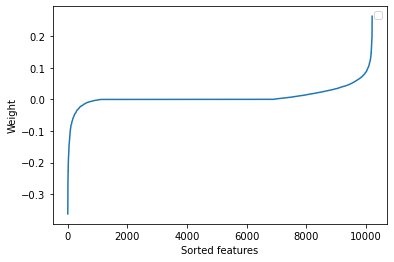

In [36]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(np.sort(CFW_weithing.D_best))
pyplot.ylabel('Weight')
pyplot.xlabel('Sorted features')
pyplot.legend()
pyplot.show()

### Something to think about... do we select features with the 'highest' weight, hence excluding the negative ones, or do we select those that have the 'highest absolute' value, accounting also for the strong negative ones?

In [37]:
argsort_features = np.argsort(-CFW_weithing.D_best)

map_list = []
selection_quota_list = [0.3, 0.5, 0.7, 0.9]

for selection_quota in selection_quota_list:
    
    n_to_select = int(selection_quota*len(argsort_features))
    selected_features = argsort_features[:n_to_select]
    
    ICM_selected = ICM_tags[:,selected_features]
    
    print("Selected {}/{} features, weights: {:.2E} to {:.2E}".format(n_to_select, len(argsort_features),
                                                                min(CFW_weithing.D_best[selected_features]),
                                                                max(CFW_weithing.D_best[selected_features])))
    
    itemKNNCBF = ItemKNNCBFRecommender(URM_train, ICM_selected)
    itemKNNCBF.fit(**best_params_ItemKNNCBF)
    
    results_dict, _ = evaluator_test.evaluateRecommender(itemKNNCBF)
    map_list.append(results_dict[5]["MAP"])
    
    

Selected 3065/10217 features, weights: 3.39E-03 to 2.64E-01
ItemKNNCBFRecommender: URM Detected 49 (0.46 %) cold items.
Similarity column 10681 ( 100 % ), 10919.31 column/sec, elapsed time 0.02 min
EvaluatorHoldout: Processed 39000 ( 55.87% ) in 30.06 sec. Users per second: 1297
EvaluatorHoldout: Processed 69804 ( 100.00% ) in 53.74 sec. Users per second: 1299
Selected 5108/10217 features, weights: 0.00E+00 to 2.64E-01
ItemKNNCBFRecommender: URM Detected 49 (0.46 %) cold items.
Similarity column 10681 ( 100 % ), 10281.99 column/sec, elapsed time 0.02 min
EvaluatorHoldout: Processed 37000 ( 53.01% ) in 30.32 sec. Users per second: 1220
EvaluatorHoldout: Processed 69804 ( 100.00% ) in 56.56 sec. Users per second: 1234
Selected 7151/10217 features, weights: 0.00E+00 to 2.64E-01
ItemKNNCBFRecommender: URM Detected 49 (0.46 %) cold items.
Similarity column 10681 ( 100 % ), 8883.01 column/sec, elapsed time 0.02 min
EvaluatorHoldout: Processed 38000 ( 54.44% ) in 30.22 sec. Users per second: 

No handles with labels found to put in legend.


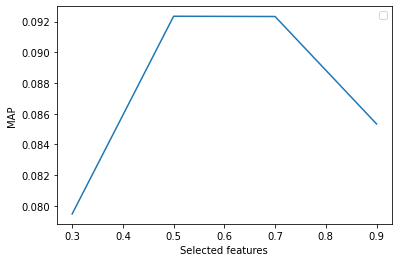

In [38]:
pyplot.plot(selection_quota_list, map_list)
pyplot.ylabel('MAP')
pyplot.xlabel('Selected features')
pyplot.legend()
pyplot.show()